In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import aiohttp
import time
from contextlib import contextmanager
import matplotlib.pyplot as plt
import seaborn as sns
import intake
import os

In [2]:
import fsspec.implementations.http as fshttp
from pelicanfs.core import PelicanFileSystem, PelicanMap, OSDFFileSystem 

In [3]:
# import dask 
# from dask_jobqueue import PBSCluster
# from dask.distributed import Client
# from dask.distributed import performance_report

In [4]:
init_year0  = '1991'
init_year1  = '2020'
final_year0 = '2071'
final_year1 = '2100'

In [5]:
# File paths
rda_url       =  'https://data.rda.ucar.edu/'
database_num  = 'd345001'
cam6_dart_url = rda_url + database_num
#
https_catalog = cam6_dart_url + '/catalogs/https/'+ database_num +'-https-zarr.json'
osdf_catalog  = cam6_dart_url + '/catalogs/osdf/'+ database_num +'-osdf-zarr.json'

### Open intake catalog

In [6]:
df_https_test = intake.open_esm_datastore(https_catalog)
df_https_test.df['path'].values

array(['https://data.rda.ucar.edu/d345001/hourly6/HR.zarr',
       'https://data.rda.ucar.edu/d345001/hourly6/TSA.zarr',
       'https://data.rda.ucar.edu/d345001/hourly6/EFLX_LH_TOT.zarr',
       'https://data.rda.ucar.edu/d345001/hourly6/ER.zarr',
       'https://data.rda.ucar.edu/d345001/weekly/VS.zarr',
       'https://data.rda.ucar.edu/d345001/weekly/PS.zarr',
       'https://data.rda.ucar.edu/d345001/weekly/Q.zarr',
       'https://data.rda.ucar.edu/d345001/weekly/US.zarr',
       'https://data.rda.ucar.edu/d345001/weekly/CLDICE.zarr',
       'https://data.rda.ucar.edu/d345001/weekly/T.zarr',
       'https://data.rda.ucar.edu/d345001/weekly/CLDLIQ.zarr'],
      dtype=object)

In [7]:
df_osdf_test = intake.open_esm_datastore(osdf_catalog)
df_osdf_test.df['path'].values

array(['osdf:///ncar/rda/d345001/hourly6/HR.zarr',
       'osdf:///ncar/rda/d345001/hourly6/TSA.zarr',
       'osdf:///ncar/rda/d345001/hourly6/EFLX_LH_TOT.zarr',
       'osdf:///ncar/rda/d345001/hourly6/ER.zarr',
       'osdf:///ncar/rda/d345001/weekly/VS.zarr',
       'osdf:///ncar/rda/d345001/weekly/PS.zarr',
       'osdf:///ncar/rda/d345001/weekly/Q.zarr',
       'osdf:///ncar/rda/d345001/weekly/US.zarr',
       'osdf:///ncar/rda/d345001/weekly/CLDICE.zarr',
       'osdf:///ncar/rda/d345001/weekly/T.zarr',
       'osdf:///ncar/rda/d345001/weekly/CLDLIQ.zarr'], dtype=object)

In [8]:
data_var = 'PS'
col_subset_https = df_https_test.search(variable=data_var)
col_subset_osdf  = df_osdf_test.search(variable=data_var)

In [9]:
dsets_https = col_subset_https.to_dataset_dict(zarr_kwargs={"consolidated": True})
#
print(f"\nDataset dictionary keys:\n {dsets_https.keys()}")
# Load the first dataset and display a summary.
dataset_key = list(dsets_https.keys())[0]
#
ds_https = dsets_https[dataset_key]


--> The keys in the returned dictionary of datasets are constructed as follows:
	'variable.frequency.component.vertical_levels'



Dataset dictionary keys:
 dict_keys(['PS.weekly.atm.1'])


In [10]:
dsets_osdf  = col_subset_osdf.to_dataset_dict()
#
ds_osdf0     = dsets_osdf[dataset_key]
ds_https0    = dsets_https[dataset_key]


--> The keys in the returned dictionary of datasets are constructed as follows:
	'variable.frequency.component.vertical_levels'


In [11]:
ds_osdf  = ds_osdf0.PS
ds_https = ds_https0.PS
ds_https

<xarray.DataArray 'PS' (member_id: 80, time: 471, lat: 192, lon: 288)>
dask.array<open_dataset-PS, shape=(80, 471, 192, 288), dtype=float64, chunksize=(80, 80, 32, 32), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) int64 1 2 3 4 5 6 7 8 9 ... 73 74 75 76 77 78 79 80
  * time       (time) datetime64[ns] 2011-01-03 2011-01-10 ... 2019-12-30
Attributes:
    long_name:  Surface pressure
    units:      Pa

CPU times: user 3.81 s, sys: 5.02 s, total: 8.83 s
Wall time: 6.56 s


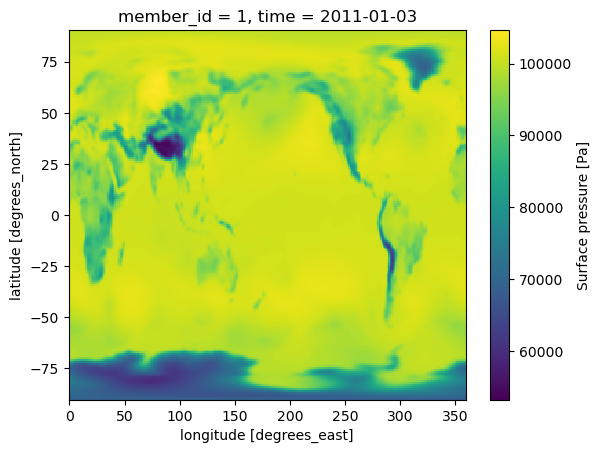

In [12]:
%%time
ds_osdf.isel(member_id=0,time=0).plot()

## Data Access Speed tests
- We will now test how long it takes to access data (via OSDF and https-only prrotocols) for various sizes using the above array

### Prepare data subsets

In [13]:
ds_osdf_1Kb  = ds_osdf.isel(lat=0,lon=0,member_id=0).isel(time=np.arange(130))
ds_https_1Kb = ds_https.isel(lat=0,lon=0,member_id=0).isel(time=np.arange(130))
#ds_https_1Kb

In [14]:
ds_osdf_1Mb  = ds_osdf.isel(time=0).isel(member_id =1+ np.arange(3))
ds_https_1Mb = ds_https.isel(time=0).isel(member_id =1+ np.arange(3))
# ds_osdf_1Mb

In [15]:
ds_osdf_10Mb  = ds_osdf.isel(member_id =4).isel(time=np.arange(24))
ds_https_10Mb = ds_https.isel(member_id =4).isel(time=np.arange(24))
# ds_osdf_10Mb

In [16]:
ds_osdf_100Mb  = ds_osdf.isel(member_id =5).isel(time=np.arange(238))
ds_https_100Mb = ds_https.isel(member_id =5).isel(time=np.arange(238))
#ds_osdf_100Mb

In [17]:
ds_osdf_200Mb  = ds_osdf.isel(member_id = 6)
ds_https_200Mb = ds_https.isel(member_id =6)
#ds_https_200Mb 

In [18]:
ds_osdf_400Mb  = ds_osdf.isel(member_id = 7 +np.arange(2))
ds_https_400Mb = ds_https.isel(member_id =7 + np.arange(2))
# ds_https_400Mb

In [19]:
ds_osdf_600Mb  = ds_osdf.isel(member_id  = 10 +np.arange(3))
ds_https_600Mb = ds_https.isel(member_id = 10 + np.arange(3))
# ds_https_600Mb

In [20]:
ds_osdf_800Mb  = ds_osdf.isel(member_id  = 14 +np.arange(4))
ds_https_800Mb = ds_https.isel(member_id = 14 + np.arange(4))
# ds_https_800Mb

In [21]:
ds_osdf_1Gb  = ds_osdf.isel(member_id  = 19 + np.arange(6)).isel(time = np.arange(410))
ds_https_1Gb = ds_https.isel(member_id = 19 + np.arange(6)).isel(time = np.arange(410))
# ds_osdf_1Gb

In [22]:
# ds_osdf_10Gb  = ds_osdf.isel(member_id  = 12 + np.arange(52))
# ds_https_10Gb = ds_https.isel(member_id = 12 + np.arange(52))
# ds_osdf_10Gb

### Access data and plot

In [23]:
# Define file path for CSV
csv_file_path = "ncar_benchmark_ap40_nodask.csv"

In [24]:
ds_osdf_list  = [ds_osdf_1Mb,ds_osdf_10Mb,ds_osdf_100Mb,ds_osdf_200Mb,ds_osdf_400Mb,
                 ds_osdf_600Mb,ds_osdf_800Mb,ds_osdf_1Gb]
ds_https_list = [ds_https_1Mb,ds_https_10Mb,ds_https_100Mb,ds_https_200Mb,ds_https_400Mb,
                 ds_https_600Mb,ds_https_800Mb,ds_https_1Gb]

In [25]:
# Number of data access calls
num_calls = 8  # Modify this as needed
n_workers = 4  # Set this to your preferred number of workers

In [26]:
# DiagnosticTimer class to keep track of runtimes
class DiagnosticTimer:
    def __init__(self):
        self.diagnostics = []

    @contextmanager
    def time(self, **kwargs):
        tic = time.time()
        yield
        toc = time.time()
        kwargs["runtime"] = toc - tic
        self.diagnostics.append(kwargs)

    def dataframe(self):
        return pd.DataFrame(self.diagnostics)

# Initialize the DiagnosticTimer
diag_timer = DiagnosticTimer()

In [27]:
# Function to check existing CSV file and determine missing runs
def load_existing_results():
    if os.path.exists(csv_file_path):
        # Load existing CSV into DataFrame
        existing_df = pd.read_csv(csv_file_path)
    else:
        # Create an empty DataFrame if the file does not exist
        existing_df = pd.DataFrame(columns=["dataset_size", "protocol", "call_number", "runtime", "MBps"])
    return existing_df

def filter_missing_runs(datasets, protocol_name, existing_df):
    # Convert dataset sizes to MB for checking, using a list of tuples
    dataset_sizes_mb = [(dataset, dataset.nbytes / (1024 ** 2)) for dataset in datasets]

    # Identify missing dataset sizes and calls
    filtered_datasets = []
    for dataset, dataset_size_mb in dataset_sizes_mb:
        for call_num in range(1, num_calls + 1):
            # Check if this dataset size and call number combination already exists
            if not ((existing_df["dataset_size"] == dataset_size_mb) &
                    (existing_df["protocol"] == protocol_name) &
                    (existing_df["call_number"] == call_num)).any():
                filtered_datasets.append((dataset, dataset_size_mb, call_num))
    
    return filtered_datasets

In [28]:
def benchmark_protocol(datasets, protocol_name, cluster=None):
    existing_df = load_existing_results()  # Load existing results as a checkpoint

    # Filter for missing runs based on existing results
    missing_runs = filter_missing_runs(datasets, protocol_name, existing_df)
    diag_timer = DiagnosticTimer()  # Initialize the diagnostic timer

    # Process each dataset and call
    for (dataset, dataset_size_mb, call_num) in missing_runs:
        # Restart the Dask cluster if provided
        if cluster is not None:
            cluster.scale(0)  # Scale down to release worker memory
            cluster.scale(n_workers)  # Scale up to required number of workers
            client.wait_for_workers(n_workers)  # Wait for workers to be ready

        # Inform the start of processing for this dataset and call
        print(f"Starting processing of dataset for protocol '{protocol_name}' (Size: {dataset_size_mb} MB) in call {call_num}")

        # Only count the time for loading dataset into memory
        dataset_copy = dataset.copy()
        with diag_timer.time(dataset_size=dataset_size_mb, protocol=protocol_name, call_number=call_num):
            dataset_copy.load()  # Load the dataset into memory

        # Convert the single call result to a DataFrame and add MBps column
        call_result_df = diag_timer.dataframe().iloc[[-1]].copy()  # Get the latest diagnostic entry
        call_result_df["MBps"] = call_result_df["dataset_size"] / call_result_df["runtime"]

        # Append this call's result to CSV
        call_result_df.to_csv(csv_file_path, mode='a', header=not os.path.exists(csv_file_path), index=False)
        print(f"Appended results for protocol '{protocol_name}', call {call_num} to '{csv_file_path}'")

        # Print statement after finishing each call
        print(f"Finished processing dataset for protocol '{protocol_name}' in call {call_num}")


In [29]:
# Run benchmark for each protocol
benchmark_protocol(ds_https_list, "HTTPS-only",cluster=None)
benchmark_protocol(ds_osdf_list, "OSDF-director",cluster=None)

# Convert diagnostics to a DataFrame for analysis
df_diagnostics = diag_timer.dataframe()


Starting processing of dataset for protocol 'HTTPS-only' (Size: 596.109375 MB) in call 7
Appended results for protocol 'HTTPS-only', call 7 to 'ncar_benchmark_ap40_nodask.csv'
Finished processing dataset for protocol 'HTTPS-only' in call 7
Starting processing of dataset for protocol 'HTTPS-only' (Size: 596.109375 MB) in call 8
Appended results for protocol 'HTTPS-only', call 8 to 'ncar_benchmark_ap40_nodask.csv'
Finished processing dataset for protocol 'HTTPS-only' in call 8
Starting processing of dataset for protocol 'HTTPS-only' (Size: 794.8125 MB) in call 1
Appended results for protocol 'HTTPS-only', call 1 to 'ncar_benchmark_ap40_nodask.csv'
Finished processing dataset for protocol 'HTTPS-only' in call 1
Starting processing of dataset for protocol 'HTTPS-only' (Size: 794.8125 MB) in call 2
Appended results for protocol 'HTTPS-only', call 2 to 'ncar_benchmark_ap40_nodask.csv'
Finished processing dataset for protocol 'HTTPS-only' in call 2
Starting processing of dataset for protocol 

KeyError: 'dataset_size'

In [31]:
# Calculate MB/s for each run
# df_diagnostics['MBps'] = df_diagnostics['dataset_size'] / df_diagnostics['runtime']
df_diagnostics = pd.read_csv(csv_file_path)
df_diagnostics

,dataset_size,protocol,call_number,runtime,MBps
0,1.265625,HTTPS-only,1,8.100158,0.156247
1,1.265625,HTTPS-only,2,7.754515,0.163211
2,1.265625,HTTPS-only,3,9.427972,0.134241
3,1.265625,HTTPS-only,4,7.436454,0.170192
4,1.265625,HTTPS-only,5,7.641388,0.165628
...,...,...,...,...,...
123,1037.812500,OSDF-director,4,29.810817,34.813286
124,1037.812500,OSDF-director,5,29.030086,35.749550
125,1037.812500,OSDF-director,6,28.728536,36.124796
126,1037.812500,OSDF-director,7,29.487627,35.194847


In [ ]:
# df_diagnostics = diag_timer.dataframe()
# df_diagnostics

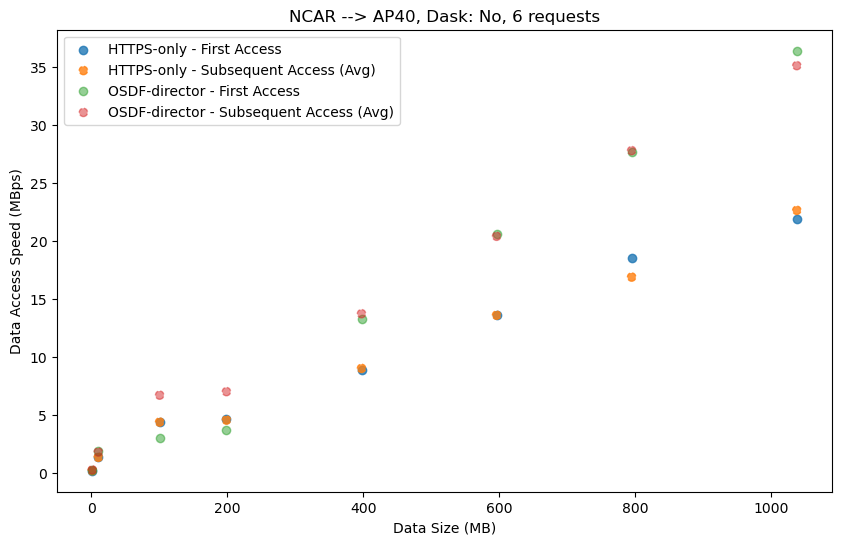

In [36]:
# Plotting MBps vs data size for each protocol and call type
# Define different alpha values for each protocol
alpha_values = {"HTTPS-only": 0.8, "OSDF-director": 0.5}  # Adjust transparency as needed
marker_style = {"HTTPS-only": "o", "OSDF-director": "x"}  # Define different markers for each protocol
#
fig, ax = plt.subplots(figsize=(10, 6))
for protocol in ["HTTPS-only", "OSDF-director"]:
    # First access (call_number == 1)
    first_access = df_diagnostics[(df_diagnostics['protocol'] == protocol) & (df_diagnostics['call_number'] == 1)]
    ax.scatter(first_access['dataset_size'], first_access['MBps'], label=f"{protocol} - First Access",
            alpha=alpha_values[protocol])

    # Subsequent access (call_number > 1)
    subsequent_access = df_diagnostics[(df_diagnostics['protocol'] == protocol) & (df_diagnostics['call_number'] > 1)]
    subsequent_access_avg = subsequent_access.groupby('dataset_size')['MBps'].mean()
    ax.scatter(subsequent_access_avg.index, subsequent_access_avg.values, 
            linestyle='--', label=f"{protocol} - Subsequent Access (Avg)",alpha=alpha_values[protocol])
    
# Customize plot appearance
ax.set_xlabel("Data Size (MB)")
ax.set_ylabel("Data Access Speed (MBps)")
ax.set_title("NCAR --> AP40, Dask: No, 6 requests")
ax.legend()
plt.show()

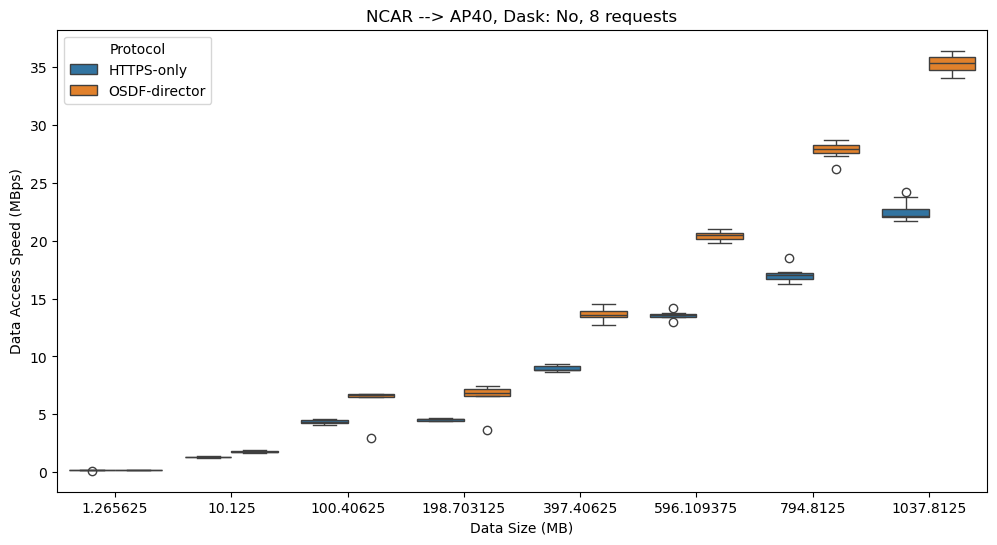

In [38]:
# Convert dataset size to categorical to control the order in the plot
df_diagnostics['dataset_size'] = df_diagnostics['dataset_size'].astype("category")

# Set the order for dataset sizes to appear in ascending order
size_order = sorted(df_diagnostics['dataset_size'].unique())

# Create the box plot
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df_diagnostics, 
    x="dataset_size", 
    y="MBps", 
    hue="protocol", 
    order=size_order
)

# Customize plot appearance
plt.xlabel("Data Size (MB)")
plt.ylabel("Data Access Speed (MBps)")
plt.title("NCAR --> AP40, Dask: No, 8 requests")
plt.legend(title="Protocol")
plt.show()